<a href="https://colab.research.google.com/github/jremeh/NLP/blob/master/fastai2_beginner_tabular_%26_collaborative_filtering_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [2]:
!pip install fastai2

     |████████████████████████████████| 184kB 2.7MB/s 


In [3]:
from fastai2.tabular.all import *

In [5]:
path = untar_data(URLs.ADULT_SAMPLE)
path.ls()

(#3) [Path('/root/.fastai/data/adult_sample/export.pkl'),Path('/root/.fastai/data/adult_sample/adult.csv'),Path('/root/.fastai/data/adult_sample/models')]

In [6]:
df = pd.read_csv(path/'adult.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


Continuous columns (like age) will be treated as float numbers to feed the model directly.

Categorical columns will be converted to unique index that will be fed to embedding layers.

We can specify our categorical and continuous column names, as well as the name of the dependent variable in `TabularDataLoaders` factory methods:

In [7]:
dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize])

The last part is the list of pre-processors we apply to our data:

- `Categorify` is going to take every categorical variable and make a map from integer to unique categories, then replace the values by the corresponding index.
- `FillMissing` will fille the missing values in the continuous variables by the median of existing values (you can choose a specific value if you prefer)
- `Normalize` will normalize the continuous variables (substract the mean and divide by the std)

In [8]:
dls.show_batch()

,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary
0,Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,False,32.000000,316588.994679,13.0,>=50k
1,Private,Some-college,Divorced,Priv-house-serv,Other-relative,White,False,68.000001,144136.999061,10.0,<50k
2,Self-emp-not-inc,Some-college,Never-married,Craft-repair,Not-in-family,White,False,34.000000,156809.000616,10.0,<50k
3,Private,Assoc-voc,Married-civ-spouse,Prof-specialty,Wife,White,False,28.000000,247819.000921,11.0,<50k
4,Private,9th,Divorced,Adm-clerical,Unmarried,White,False,36.000000,732569.013177,5.0,<50k
5,Private,Assoc-voc,Married-civ-spouse,Craft-repair,Husband,White,False,41.000000,173681.999544,11.0,>=50k
6,Private,Some-college,Never-married,Craft-repair,Not-in-family,Black,False,34.000000,405385.994396,10.0,<50k
7,Private,Some-college,Never-married,Adm-clerical,Own-child,White,False,20.000001,103276.999986,10.0,<50k
8,Self-emp-not-inc,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,False,68.000001,69249.002990,9.0,>=50k
9,Self-emp-not-inc,Doctorate,Never-married,Prof-specialty,Not-in-family,White,False,36.000000,343720.998367,16.0,>=50k


**Note**: Sometimes with tabular data, your y's may be encoded (such as 0 and 1). In such a case you should explicitly pass `y_block = CategoryBlock` in your constructor so fastai won't presume you are doing regression.

In [9]:
learn = tabular_learner(dls, metrics=accuracy)

`fine_tune` method won't be useful as we're not using pretrained model

In [10]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.365220,0.348718,0.842291,00:08


/usr/local/lib/python3.6/dist-packages/fastai2/callback/schedule.py:68: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx = (pos >= pcts).nonzero().max()


In [11]:
learn.show_results()

,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary,salary_pred
0,5.0,12.0,3.0,13.0,1.0,5.0,1.0,-0.484704,0.145714,-0.423777,0.0,0.0
1,5.0,16.0,1.0,2.0,2.0,5.0,1.0,0.028017,-0.239045,-0.032213,0.0,0.0
2,5.0,16.0,5.0,9.0,3.0,5.0,1.0,-0.704442,0.021675,-0.032213,0.0,0.0
3,7.0,12.0,5.0,13.0,3.0,2.0,1.0,-0.924180,-1.147583,-0.423777,1.0,0.0
4,5.0,16.0,5.0,13.0,4.0,5.0,1.0,-1.290410,-0.439000,-0.032213,0.0,0.0
5,5.0,10.0,3.0,2.0,1.0,2.0,1.0,0.321001,-0.607177,1.142480,0.0,0.0
6,5.0,8.0,5.0,2.0,5.0,3.0,1.0,-0.191721,-0.672702,0.750915,0.0,0.0
7,5.0,2.0,5.0,13.0,4.0,5.0,1.0,-1.363656,0.440995,-1.206906,0.0,0.0
8,5.0,10.0,3.0,14.0,1.0,5.0,1.0,-0.484704,-0.133782,1.142480,1.0,1.0


In [12]:
learn.predict(df.iloc[0])

(   workclass  education  marital-status  ...    fnlwgt  education-num  salary
 0        5.0        8.0             3.0  ... -0.839156       0.750915     1.0
 
 [1 rows x 11 columns], tensor(1), tensor([0.4132, 0.5868]))

Prediction on a new data frame

In [13]:
test_df = df.copy()
test_df.drop(['salary'], axis=1, inplace=True)
dl = learn.dls.test_dl(test_df)

In [17]:
learn.get_preds(dl=dl)

(tensor([[0.4132, 0.5868],
         [0.4597, 0.5403],
         [0.9883, 0.0117],
         ...,
         [0.6110, 0.3890],
         [0.6088, 0.3912],
         [0.6777, 0.3223]]), None)

# Collaborative filtering

Collaborative filtering is a technique that can filter out items that a user might like on the basis of reactions by similar users. It works by searching a large group of people and finding a smaller set of users with tastes similar to a particular user.

In [18]:
from fastai2.tabular.all import *
from fastai2.collab import *

In [19]:
path = untar_data(URLs.ML_100k)

In [20]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      usecols=(0,1,2), names=['user','movie','rating'])
ratings.head()

,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [21]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [22]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,title
0,196,242,3,Kolya (1996)
1,63,242,3,Kolya (1996)
2,226,242,5,Kolya (1996)
3,154,242,3,Kolya (1996)
4,306,242,5,Kolya (1996)


In [23]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)

In [24]:
dls.show_batch()

,user,title,rating
0,655,"Mrs. Brown (Her Majesty, Mrs. Brown) (1997)",3
1,251,"Hunt for Red October, The (1990)",3
2,7,Henry V (1989),5
3,666,Nobody's Fool (1994),4
4,846,Beyond Rangoon (1995),4
5,378,"Crow, The (1994)",2
6,189,Dave (1993),2
7,194,"Godfather: Part II, The (1974)",4
8,104,"Saint, The (1997)",2
9,413,Contact (1997),4


fastai can create and train a collaborative filtering model by using `collab_learner`:

It uses a simple dot product model with 50 latent factors. To train it using the 1cycle policy, we just run this command:

In [25]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [26]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.938203,0.953455,00:12
1,0.863285,0.876162,00:12
2,0.735032,0.838411,00:12
3,0.610484,0.826075,00:12
4,0.480924,0.826782,00:12


## Interpretation

In [28]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

### Movie Bias

Our model has learned one bias per movie, a unique number independent of users that can be interpreted as the intrinsic "value" of the movie. We can grab the bias of each movie in our top_movies list with the following conmmand:

In [30]:
movie_bias = learn.model.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [32]:
mean_ratings = ratings.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

Movies with the worst bias

In [33]:
item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3551),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.2736), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2459), 'Coneheads (1993)', 2.2195121951219514),
 (tensor(-0.2456), 'Kansas City (1996)', 2.260869565217391),
 (tensor(-0.2454),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2453), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2406), "McHale's Navy (1997)", 2.1884057971014492),
 (tensor(-0.2352), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2313), 'Beautician and the Beast, The (1997)', 2.313953488372093),
 (tensor(-0.2265), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2251), 'Flintstones, The (1994)', 2.064516129032258),
 (tensor(-0.2248), 'Stuart Saves His Family (1995)', 2.125),
 (tensor(-0.2185), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2147), 'Beverly Hills Ninja (1997)', 2.3125),
 (tensor(-0.2121), "Stephen King's The Langoliers (

In [34]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.5483), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.5480), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5374), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.5261), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5192), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5175), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.5132), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5023), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4959), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.4946), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4793), 'Apt Pupil (1998)', 4.1),
 (tensor(0.4568), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4501), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.4419), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.4403), 'Henry V (1989)', 4.137096774193548)]

### Movie weight

Now let's try to analyze the latent factors our model has learned. We can grab the weights for each movie in top_movies the same way as we did for the bias before.

In [35]:
movie_w = learn.model.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 50])

PCA to reduce the dimensions

Principal component analysis (PCA) is a technique used to emphasize variation and bring out strong patterns in a dataset. It's often used to make data easy to explore and visualize.

In [36]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [37]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [41]:
#Best
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.0348), 'Trainspotting (1996)'),
 (tensor(0.8763), 'Brazil (1985)'),
 (tensor(0.8258), 'Clockwork Orange, A (1971)'),
 (tensor(0.8060), 'Cable Guy, The (1996)'),
 (tensor(0.7687), 'Keys to Tulsa (1997)'),
 (tensor(0.7399), 'Jude (1996)'),
 (tensor(0.7381), 'Heavenly Creatures (1994)'),
 (tensor(0.7346), 'Lost Highway (1997)'),
 (tensor(0.7254), 'Very Brady Sequel, A (1996)'),
 (tensor(0.7228), 'Serial Mom (1994)')]

In [42]:
#Worst
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.1346), 'Titanic (1997)'),
 (tensor(-1.0563), 'Braveheart (1995)'),
 (tensor(-0.9913), 'Raiders of the Lost Ark (1981)'),
 (tensor(-0.9173), 'Forrest Gump (1994)'),
 (tensor(-0.8882), 'Field of Dreams (1989)'),
 (tensor(-0.8744), "It's a Wonderful Life (1946)"),
 (tensor(-0.8702), 'Top Gun (1986)'),
 (tensor(-0.8406), 'Back to the Future (1985)'),
 (tensor(-0.8399), 'Affair to Remember, An (1957)'),
 (tensor(-0.8343), 'Indiana Jones and the Last Crusade (1989)')]

Second dimension

In [43]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [44]:
#Best
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.0348), 'Trainspotting (1996)'),
 (tensor(0.8763), 'Brazil (1985)'),
 (tensor(0.8258), 'Clockwork Orange, A (1971)'),
 (tensor(0.8060), 'Cable Guy, The (1996)'),
 (tensor(0.7687), 'Keys to Tulsa (1997)'),
 (tensor(0.7399), 'Jude (1996)'),
 (tensor(0.7381), 'Heavenly Creatures (1994)'),
 (tensor(0.7346), 'Lost Highway (1997)'),
 (tensor(0.7254), 'Very Brady Sequel, A (1996)'),
 (tensor(0.7228), 'Serial Mom (1994)')]

In [45]:
#Worst
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.1346), 'Titanic (1997)'),
 (tensor(-1.0563), 'Braveheart (1995)'),
 (tensor(-0.9913), 'Raiders of the Lost Ark (1981)'),
 (tensor(-0.9173), 'Forrest Gump (1994)'),
 (tensor(-0.8882), 'Field of Dreams (1989)'),
 (tensor(-0.8744), "It's a Wonderful Life (1946)"),
 (tensor(-0.8702), 'Top Gun (1986)'),
 (tensor(-0.8406), 'Back to the Future (1985)'),
 (tensor(-0.8399), 'Affair to Remember, An (1957)'),
 (tensor(-0.8343), 'Indiana Jones and the Last Crusade (1989)')]

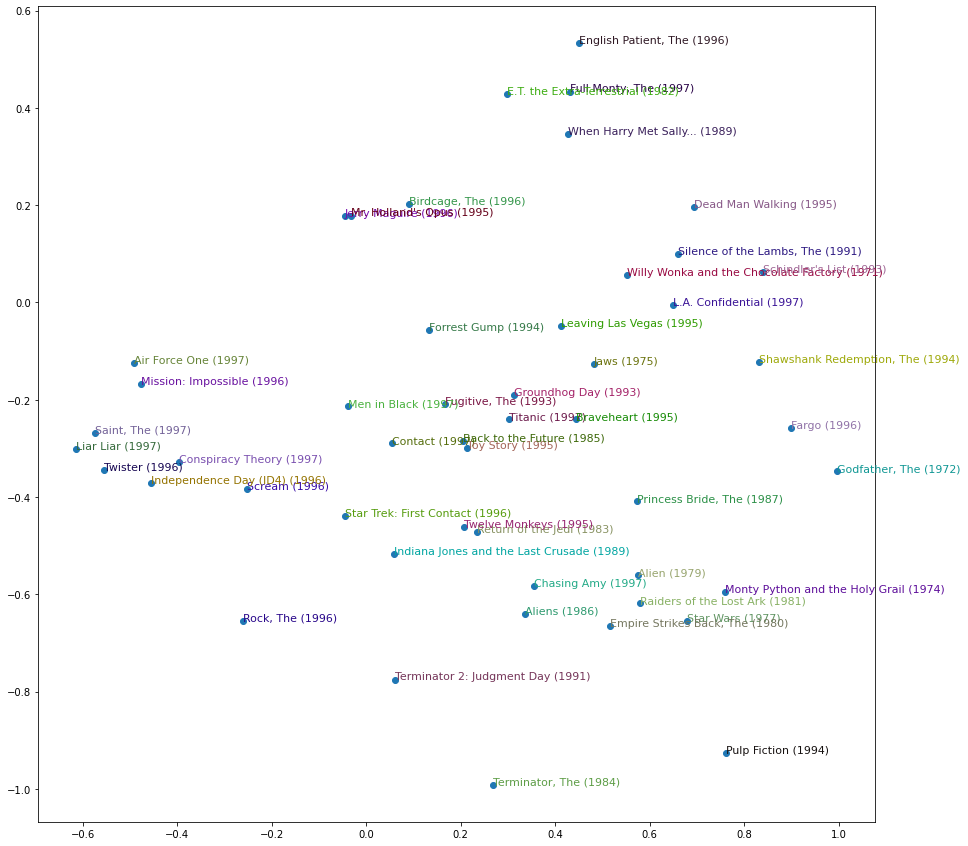

In [46]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()